# Bare bones sweep over regularisation parameter for several algorithms 

In [1]:
from cil.recon import FDK
from cil.utilities.display import show2D
import matplotlib.pyplot as plt
import numpy as np
import os
import util

# Choose and load data set

In [2]:
data_set_identifier = 'ta' #'solid_disc' 'ta' 'tb' 'tc' 'td'
datafull = util.load_htc2022data('../HTC2022/data/htc2022_'+data_set_identifier+'_full.mat')

In [3]:
ref = util.loadImg('../HTC2022/data/segmented_references/htc2022_'+data_set_identifier+'_full_recon_fbp_seg.png')

# All parameters here

In [4]:
# Reduce data
ang_start = 0
ang_range = 50

# Image size
im_size = 512

# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted
def ub_mask_str(ub_mask_type):
    if ub_mask_type ==1:
        typ = '97% radius'
    elif ub_mask_type == 2:
        typ = 'fitted'
    elif ub_mask_type is None:
        typ = 'none'
    return typ

basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = 0

# Reconstruction
num_iters = 2000

# Segment
segment_type = 2  # 1 basic thresholding, 2 crazy



# Reduce data

In [5]:
data = util.generate_reduced_data(datafull, ang_start, ang_range)
# data = util.load_htc2022data(os.path.abspath("C:/Users/ofn77899/Data/HTC2022/test_input/A.mat"), dataset_name="CtDataLimited")
ang_range = np.abs(data.geometry.angles[-1]-data.geometry.angles[0])


# Image geometry

In [6]:
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = im_size
ig.voxel_num_y = im_size

# Preprocess

In [7]:
data_renorm = util.correct_normalisation(data)
data_pad = util.pad_zeros(data_renorm)
data_BHC = util.apply_BHC(data_pad)

## Circle fitting

In [8]:
circle_parameters = util.find_circle_parameters(data, ig)
outercircle = ig.allocate(0)
util.fill_circular_mask(circle_parameters, outercircle.as_array(), 1, *outercircle.shape)
# fill the circle with 0 in a smaller circle to highlight the circumference
smaller_circle = circle_parameters.copy()
smaller_circle[0] = smaller_circle[0] - 2
print (circle_parameters, smaller_circle)
innercircle = ig.allocate(0)
util.fill_circular_mask(smaller_circle, innercircle.as_array(), 1, *innercircle.shape)

dcircle = outercircle - innercircle


FDK recon

Input Data:
	angle: 101
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False

[234.90763241 248.39962341 250.82002421] [232.90763241 248.39962341 250.82002421]


In [9]:

# show FDK and gradient and circle
def recon_FDK(data, preprocess_data=False):
    if preprocess_data:
        data_renorm = util.correct_normalisation(data)
        data_pad = util.pad_zeros(data_renorm)
        data_BHC = util.apply_BHC(data_pad)
    else:
        data_BHC = data
    recon = FDK(data_BHC, ig).run()
    return recon
recons = [recon_FDK(datafull, preprocess_data=True)]
titles = ['Full angular range FDK']
recons.append( recon_FDK(data, preprocess_data=False) )
titles.append( 'Limited Angle FDK' )


FDK recon

Input Data:
	angle: 721
	horizontal: 732

Reconstruction Volume:
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False

FDK recon

Input Data:
	angle: 101
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False



In [10]:
def segment_and_calculate_score(recon, segmethod, ref):
    
    if segmethod == 1:
        ss = util.apply_global_threshold(recon)
    elif segment_type == 2:
        ss = util.apply_crazy_threshold(recon)
    segmentation = util.flipud_unpack(ss)
    
    score = util.calcScoreArray(segmentation, ref)
        
    return score, segmentation

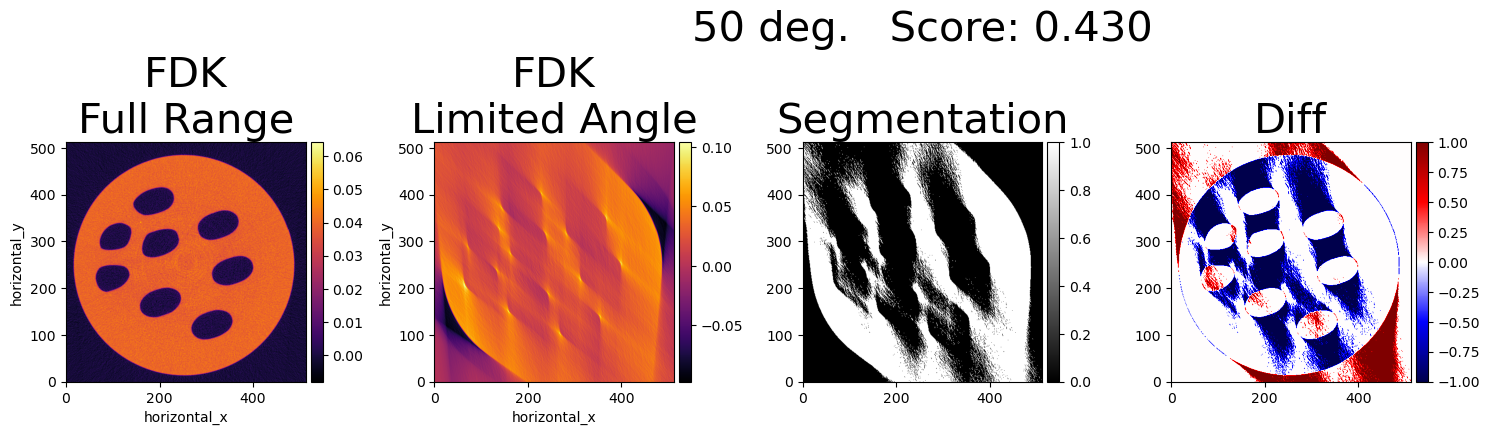

In [11]:
# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)
scse = [ segment_and_calculate_score(el, 2, ref) for el in recons ] 
segmetation_text = '{:d} deg.   Score: {:.3f}\n\nSegmentation'.format(int(ang_range), scse[1][0])
show2D([recons[0], recons[1],  
               np.flipud(scse[1][1]), 
              np.flipud(scse[1][1].astype('float32')-ref.astype('float32'))], 
              title=['FDK\nFull Range', 'FDK\nLimited Angle' , segmetation_text, 
                     # '{:d} deg.   Score: {:.3f}\n\nSegmentation'.format(int(ang_range), scse[1][0]), 
                     'Diff'], 
              cmap=['inferno', 'inferno', 'gray', 'seismic'], 
              num_cols=4, 
              )

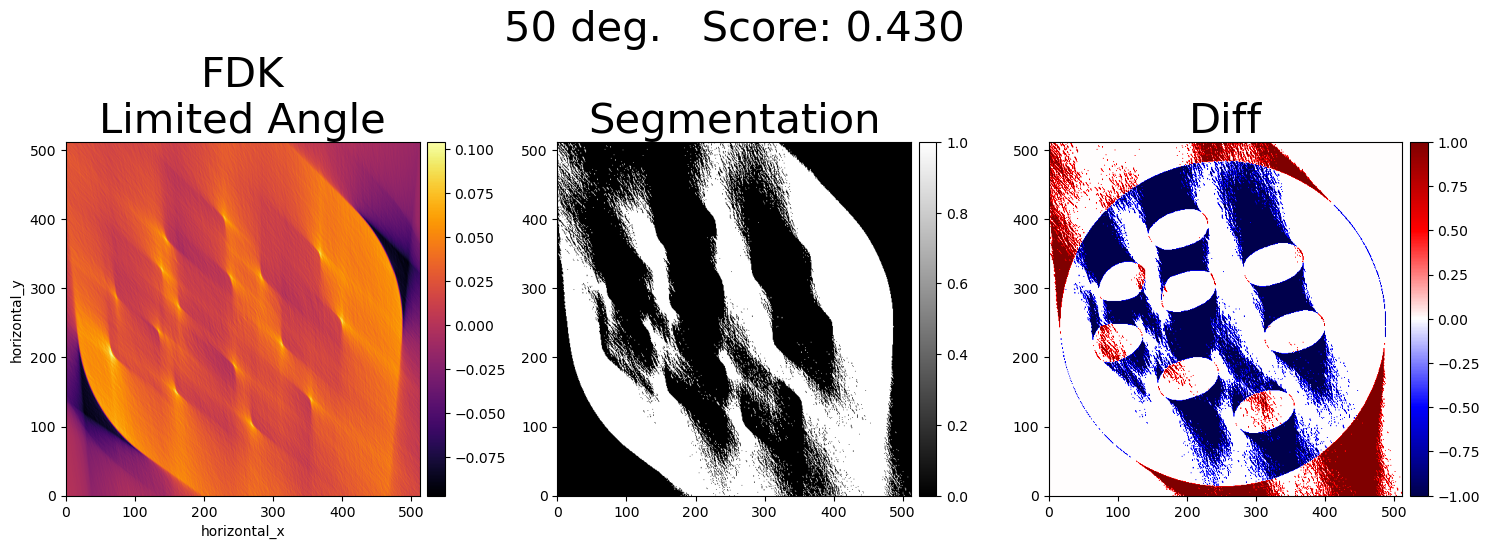

In [12]:
# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)
scse = [ segment_and_calculate_score(el, 2, ref) for el in recons ] 
segmetation_text = '{:d} deg.   Score: {:.3f}\n\nSegmentation'.format(int(ang_range), scse[1][0])
show2D([recons[1],  
               np.flipud(scse[1][1]), 
              np.flipud(scse[1][1].astype('float32')-ref.astype('float32'))], 
              title=['FDK\nLimited Angle' , segmetation_text, 
                     # '{:d} deg.   Score: {:.3f}\n\nSegmentation'.format(int(ang_range), scse[1][0]), 
                     'Diff'], 
              cmap=['inferno', 'gray', 'seismic'], 
              num_cols=3, 
              )

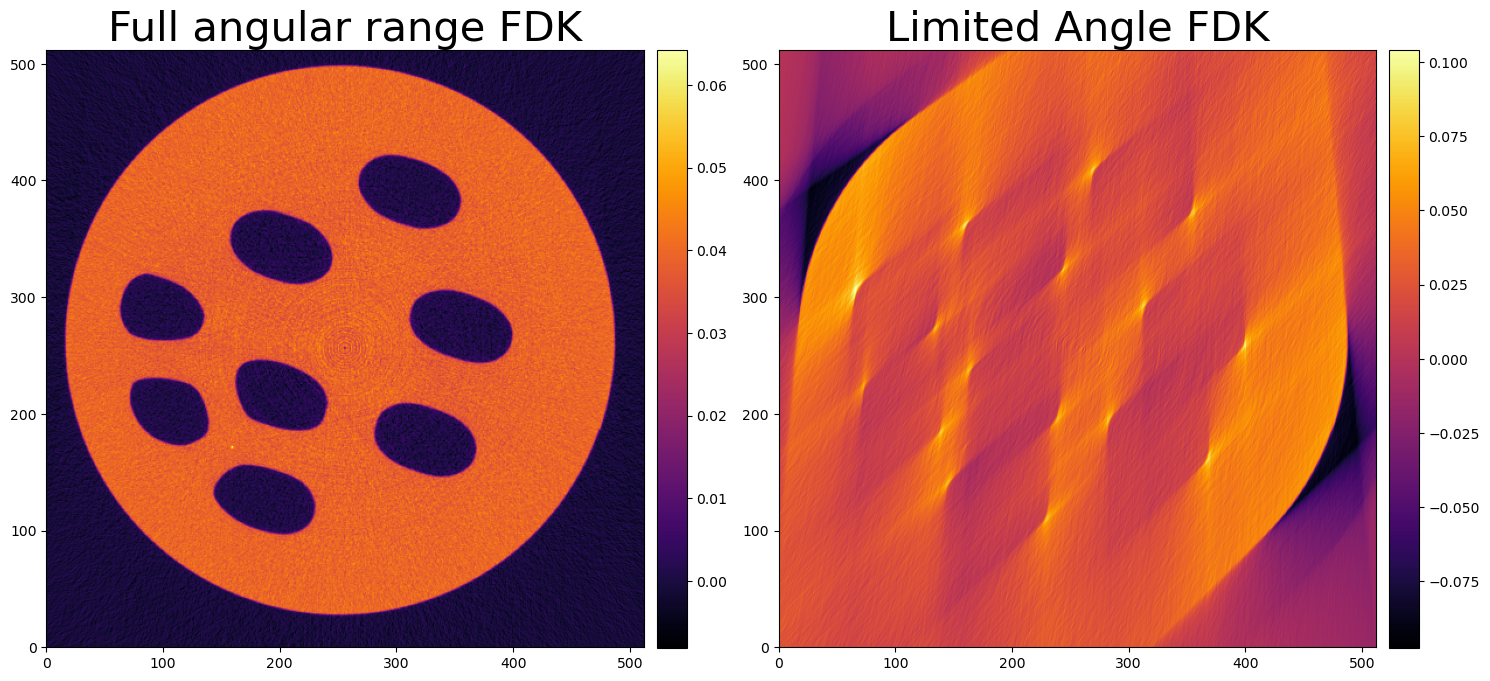

In [13]:

# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)
show2D([util.flipud_unpack(el) for el in recons], title=titles, cmap='inferno')


In [14]:
# Upper bound mask 0.97 circle or fitted 
def create_circular_mask(ub_mask_type, ub_val, basic_mask_radius=0.97, data=None, ig=None):
    if ub_mask_type == 1:
        ub = ig.allocate(ub_val)
        ub = util.apply_circular_mask(ub, basic_mask_radius)
    elif ub_mask_type == 2:
        # sample mask with upper bound to acrylic attenuation
        ub = ig.allocate(0)
        circle_parameters = util.find_circle_parameters(data, ig)
        util.fill_circular_mask(circle_parameters, ub.array, \
            ub_val, *ub.shape)
    return ub

In [15]:
# Show the procedure for the circle fit
from skimage.filters import threshold_otsu, threshold_multiotsu
mag = util.calculate_gradient_magnitude(recons[1])

# initial binary mask
thresh = threshold_otsu(mag.array)
binary_mask = mag.array > thresh

disk = create_circular_mask(2, ub_val, data=data, ig=ig)


FDK recon

Input Data:
	angle: 101
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False



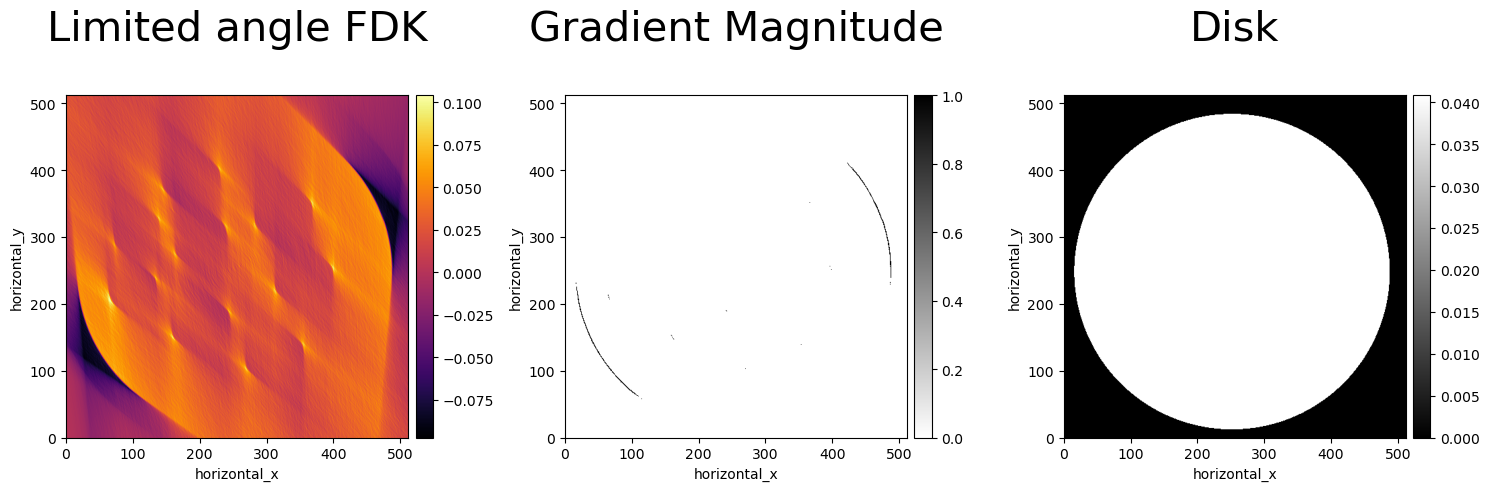

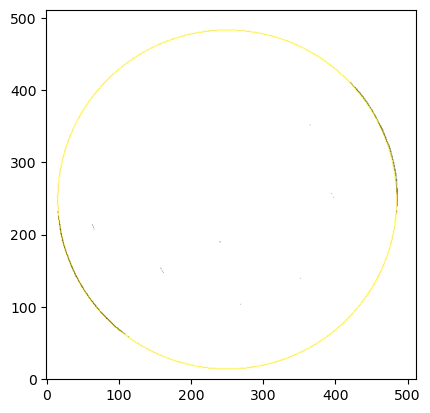

In [16]:
import matplotlib.pyplot as plt
bm = ig.allocate(0)
bm.fill(binary_mask)

show2D([recons[1], bm, disk], cmap=['inferno', 'gray_r', 'gray'],
       title=['Limited angle FDK\n', 'Gradient Magnitude\n', 'Disk\n'], num_cols=3)

plt.imshow(bm.as_array(), cmap='gray_r', origin='lower')
plt.imshow((outercircle - innercircle).as_array(), cmap='hot_r', alpha=0.5, origin='lower', vmin=0, vmax=3)


# Lower bound mask

In [17]:
# lower bound
lb = ig.allocate(0.0)

# Utility function to compute score and make plots compactly

In [18]:
def score_plot(recon_list, title_list, segmethod, ref, do_plot=5):
    
    seg_list = []
    for rr in recon_list:
        if segmethod == 1:
            ss = util.apply_global_threshold(rr)
        elif segment_type == 2:
            ss = util.apply_crazy_threshold(rr)
        seg_list.append(util.flipud_unpack(ss))
    
    score_list = []
    for rr in seg_list:
        score_list.append(util.calcScoreArray(rr, ref))
    
    if do_plot:
        show2D(recon_list, title_list, num_cols=do_plot)
        show2D(seg_list, title_list, num_cols=do_plot)
        
        diffseg_list = []
        for rr in seg_list:
            diffseg_list.append(rr.astype('float32')-ref.astype('float32'))
        show2D(diffseg_list, title_list, num_cols=do_plot)
    
    for i, x in enumerate(title_list):
        print(score_list[i],'\t',x )
    
    return score_list, seg_list

# Building the Optimisation Problem and solving it with PDHG

In [19]:
from cil.optimisation.functions import L2NormSquared, L1Norm, MixedL21Norm, BlockFunction, KullbackLeibler
from cil.optimisation.operators import GradientOperator, BlockOperator, FiniteDifferenceOperator
from cil.plugins.tigre import ProjectionOperator

def configure_F_K(ig, data, iso_weight, aniso_weight_x, fidelity_weight):
# FinDiff operators in y, x (numpy)
    Grad = GradientOperator(ig)
    A = ProjectionOperator(ig, data.geometry)
    Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
    K12x = BlockOperator(A, Grad, Dx)

    omega = fidelity_weight
    alpha = iso_weight
    alpha_dx = aniso_weight_x
    
    f1 = omega*L2NormSquared(b=data)  
    f2 = alpha*MixedL21Norm()
    
    f_dx = alpha_dx*L1Norm()
    F12x = BlockFunction(f1, f2, f_dx)
    if alpha_dx < 1e-7:
        F12x = BlockFunction(f1, f2)
        K12x = BlockOperator(A, Grad)
    
    normK = K12x.norm()
    sigma = 1.0
    tau = 1.0/(sigma*normK**2)
    return F12x, K12x

In [23]:
# configurations to produce the plots for the presentation

# ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted, None for no mask

configs = {
    'LS+isoTV':{'iso_weight':0.01, 'aniso_weight_x': 0.03 * 1e-7, 'ub_mask_type': None, 'submitted_algo':False, 'step_size_submitted':True},
    'LS+isoTV+disk':{'iso_weight':0.01, 'aniso_weight_x': 0.03 * 1e-7, 'ub_mask_type': 2, 'submitted_algo':False, 'step_size_submitted':True}, 
    'LS+isoTV+xTV+disk':{'iso_weight':0.01, 'aniso_weight_x': 0.03 , 'ub_mask_type': 1, 'submitted_algo':True, 'step_size_submitted':True},
    'LS+isoTV+xTV+disk_converged':{'iso_weight':0.01, 'aniso_weight_x': 0.03 , 'ub_mask_type': 2, 'submitted_algo':True, 'step_size_submitted':False}
}

which = 'LS+isoTV+xTV+disk'

iso_weight = configs[which]['iso_weight']
aniso_weight_x = configs[which]['aniso_weight_x']
ub_mask_type = configs[which]['ub_mask_type']
submitted_algo = configs[which]['submitted_algo']
step_size_submitted = configs[which]['step_size_submitted']


In [24]:
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import IndicatorBox, ZeroFunction
from cil.framework import AcquisitionData
from algo import IndicatorBoxPixelwise
from skimage.transform import rotate 

recons = []
titles = []

fidelity_weight = 90/ang_range
# iso_weight = 0.01
# aniso_weight_x = 0.03

num_iterations = 2000
# step_size_submitted = False

segmentations = []
scores = []

# submitted_algo = False



if submitted_algo:
    from algo import pdhg_rotate_isotv_anisotv
    from main import create_lb_ub
    lb_val = 0
    lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                                ub_val, lb_val, basic_mask_radius, lb_inner_radius)
    pars = [fidelity_weight, iso_weight, aniso_weight_x]
    sol, unrotated = pdhg_rotate_isotv_anisotv(data_BHC, ig, lb, ub, *pars, num_iters=2000, update_objective_interval=100, verbose=1)
else:
    # notice that the fitted mask wants the data non-preprocessed
    if ub_mask_type == 1:
        ub = create_circular_mask(1, ub_val, basic_mask_radius=basic_mask_radius, data=data_BHC, ig=ig)
    elif ub_mask_type == 2:
        ub = create_circular_mask(2, ub_val, data=data, ig=ig)
    elif ub_mask_type is None:
        pass
    else:
        raise ValueError('Unknown mask type. Expected 1 or 2, got {}'.format(ub_mask_type))

    
    if ub_mask_type is None:
        print("no rotation")
        F, K = configure_F_K(ig, data_BHC, iso_weight, aniso_weight_x, fidelity_weight)
        G = ZeroFunction()
    elif (ub_mask_type == 1 or ub_mask_type == 2):
        ag_rotated = data_BHC.geometry.copy()
    
        ang_middle = (data_BHC.geometry.angles[0]+data_BHC.geometry.angles[-1])/2
        #ang_start = np.abs(data.geometry.angles[0])
        #ang_range = np.abs(data.geometry.angles[-1]-data.geometry.angles[0])
        #ang_rotate = (ang_start+ang_range/2.0)
        ag_rotated.set_angles(data_BHC.geometry.angles - ang_middle, angle_unit='degree')
        
        data_rotated = AcquisitionData(data_BHC.as_array(), geometry=ag_rotated)

        F, K = configure_F_K(ig, data_rotated, iso_weight, aniso_weight_x, fidelity_weight)

        lb_copy = ig.allocate(0)
        ub_copy = ub.copy()
        lb_copy.array = rotate(lb.as_array(), -ang_middle)
        ub_copy.array = rotate(ub.as_array(), -ang_middle)

        G = IndicatorBoxPixelwise(lower=lb_copy, upper=ub_copy)
    

    normK = K.norm()
    if step_size_submitted:
       sigma = 1.0
       tau = 1 / (sigma * normK**2)
    else:
       sigma = 1.0 / normK
       tau = 1.0 / normK

    algo = PDHG(operator=K, f=F, g=G, max_iteration=num_iterations, update_objective_interval=1000, sigma=sigma, tau=tau,)
    algo.run()
    sol =  algo.solution.copy()
    if ub_mask_type is not None:
        # do the rotation if we pass a mask
        sol.array = rotate(sol.as_array(), ang_middle)
    
    
    # diffseg_list.append(rr.astype('float32')-ref.astype('float32'))

recons.append(sol)

score, segmentation = segment_and_calculate_score(recons[-1], segment_type, ref)
scores.append(score)
segmentations.append(segmentation)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          3.05710e+05
      100       2000         0.032          4.86971e+01
      200       2000         0.032          4.50006e+01
      300       2000         0.032          4.36199e+01
      400       2000         0.032          4.28442e+01
      500       2000         0.032          4.23424e+01
      600       2000         0.032          4.19895e+01
      700       2000         0.032          4.17264e+01
      800       2000         0.032          4.15265e+01
      900       2000         0.032          4.13695e+01
     1000       2000         0.032          4.12412e+01
     1100       2000         0.032          4.11366e+01
     1200       2000         0.033          4.10480e+01
     1300       2000         0.033          4.09731e+01
     1400       2000         0.033          4.09084e+01
     1500       2000         0.033          4.08

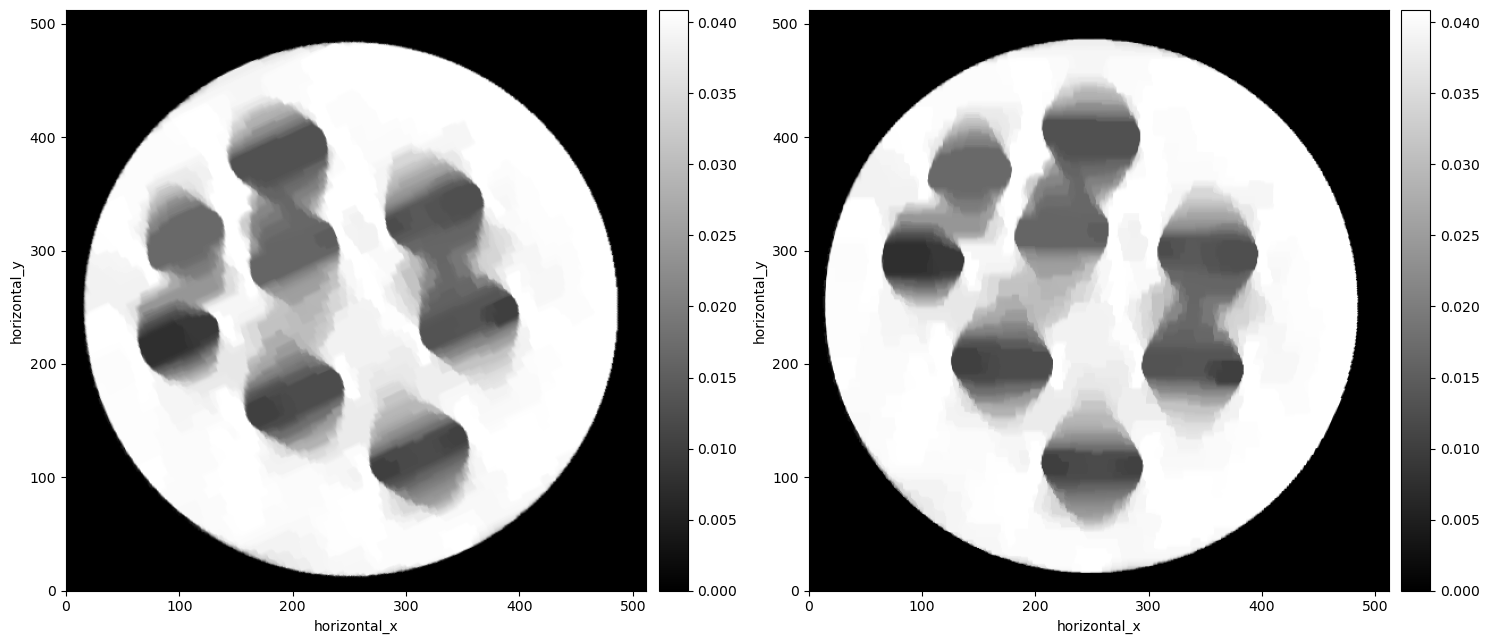

In [22]:
show2D([sol, unrotated])

is_default 


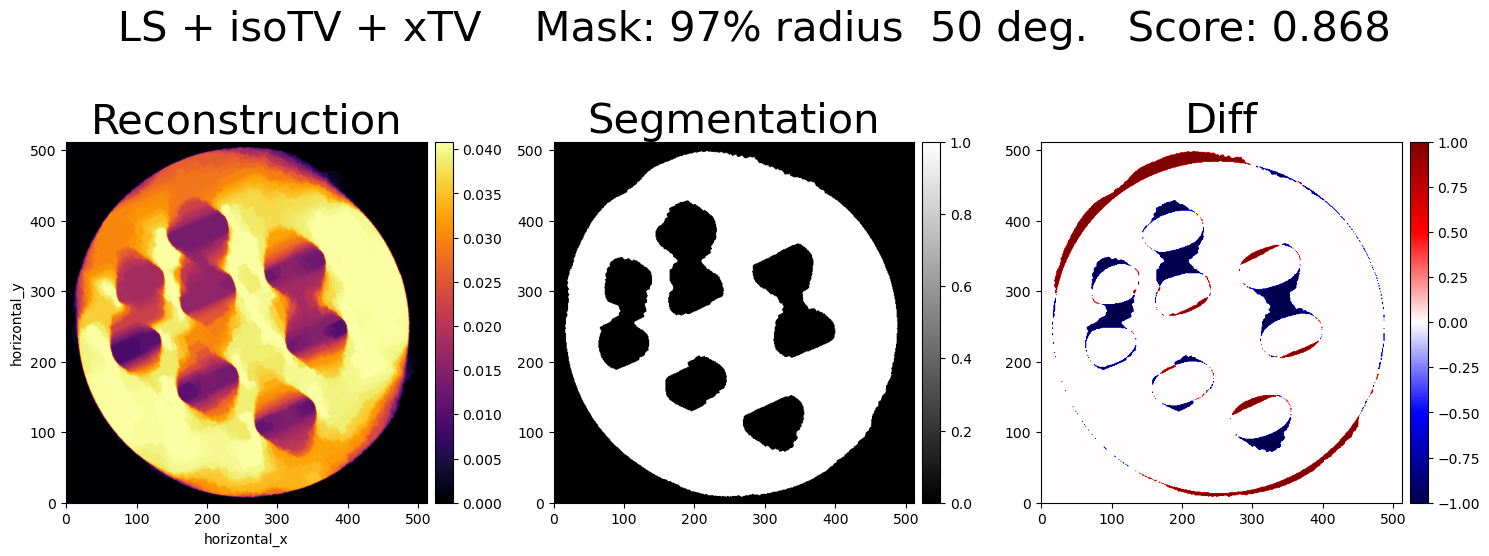

In [25]:

# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)

tt = 'LS + {} TV + {} anisoTV   Mask: {}   '
t =  tt.format(iso_weight, aniso_weight_x, ub_mask_str(ub_mask_type))
# the submitted algorithms did not use the default PDHG settings
is_default = '' if step_size_submitted else 'Converged'
print ("is_default", is_default)
tt = '{}   LS + isoTV + xTV    Mask: {}'
if aniso_weight_x < 1e-7:
       tt = '{}   LS + isoTV    Mask: {}'
t = tt.format(is_default, ub_mask_str(ub_mask_type))
titles.append(t)

test = show2D([recons[-1], 
               np.flipud(segmentations[-1]), 
              np.flipud(segmentations[-1].astype('float32')-ref.astype('float32'))], 
              title=['Reconstruction', 
                     '{}  {:d} deg.   Score: {:.3f}\n\nSegmentation'.format(titles[-1], int(ang_range), scores[-1]), 
                     'Diff'], 
              cmap=['inferno', 'gray', 'seismic'], num_cols=3, 
              )

# test.figure.suptitle(titles[-1], fontsize=16, y=0.7)
# import matplotlib.pyplot as plt
# plt.tight_layout()
# test.figure.show()


In [ ]:
# plot solution not rotated back

# uncomment if compare does not exist already
# compare = [algo.solution.copy()]
# ctitle = [which]


In [ ]:
compare.append(algo.solution.copy())
ctitle.append(which)

In [ ]:
# show2D(compare, title=ctitle, cmap='inferno')

for x,y in zip(compare, ctitle):
    show2D(x,title=y, cmap='inferno')

In [ ]:


test = show2D([recons[-1], 
               np.flipud(segmentations[-1]), 
              np.flipud(segmentations[-1].astype('float32')-ref.astype('float32'))], 
              title=['Reconstruction', 
                     '{}  {:d} deg.   Score: {:.3f}\n\nSegmentation'.format(titles[-1], int(ang_range), scores[-1]), 
                     'Diff'], 
              cmap=['inferno', 'gray', 'seismic'], num_cols=3, 
              )
# test.figure.suptitle(titles[-1], fontsize=16, y=0.7)
# import matplotlib.pyplot as plt
# plt.tight_layout()
# test.figure.show()

In [ ]:
lb1, ub1 = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                                ub_val, lb_val, basic_mask_radius, lb_inner_radius)
show2D([ub, ub1, ub-ub1], cmap=['gray','gray', 'seismic'])